# Bubble Lab Test

This script looks into data recorded during DAS testing in UW's saltwater test tank where we produced bubbles in various rates.

In [7]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import scipy
import os
import pandas as pd
import DASfuncs
import importlib
import sys

importlib.reload(DASfuncs)

<module 'DASfuncs' from '/Users/graeffd/Documents/projects/2022-25_SPI_GreenFjord/analysis/scripts/GreenFjord_DAS/DASfuncs.py'>

In [8]:
t_start = datetime.datetime(2023,6,1,22,55,20)
t_end = datetime.datetime(2023,6,1,22,56,20)

files = DASfuncs.get_Onyx_h5('../../../data/lab/SaltwaterTankTest/DAS_data/', t_start, t_end)
print('{} files in directory'.format(len(files)))

1 files in directory


In [9]:
# read the data
data_rec, t_rec, attrs = DASfuncs.read_Onyx_h5(files)#, cha_start=7, cha_end=-7)

In [10]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)

In [11]:
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')
print('Data filles {:.2} GB of memory.'.format(sys.getsizeof(data_filled)/2**30))

Data filles 0.24 GB of memory.


Text(0.5, 0, 'Time [s]')

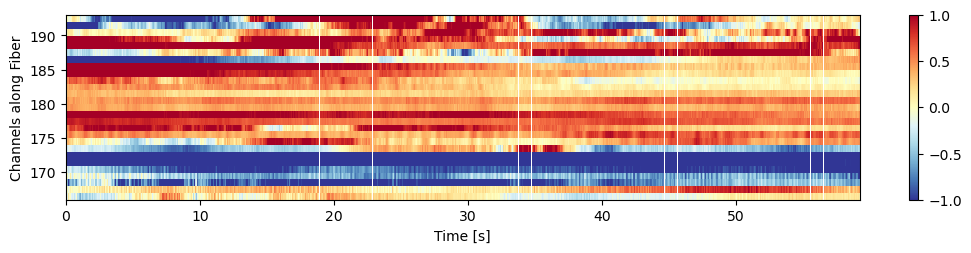

In [14]:
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))

# left plot
im = ax.imshow(data_filled.T, aspect='auto',
             origin='lower',
             vmin=-1,#np.percentile(data[~np.isnan(data)],5),
             vmax=1,#np.percentile(data[~np.isnan(data)],95),
             extent=[0,data_rec.shape[0]/(attrs['PulseRate']), 
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data_rec.shape[1]],
             cmap='RdYlBu_r',
             interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

In [15]:
# get data gaps
gap_list = DASfuncs.get_gaps(time_list, attrs)

Text(0.5, 0, 'Time')

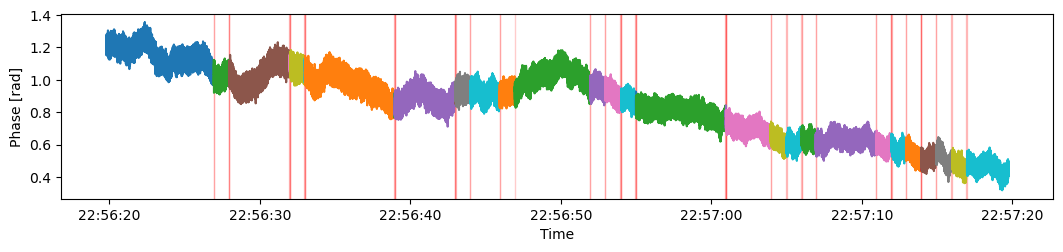

In [16]:
# plot time series with different colors indicating chunks of data
cha = 12
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, data_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    ax.plot(DASfuncs.sintela_to_datetime(t),d[:,cha]) # with datetime formatting
for gap in gap_list:
    # plt.axvspan(gap[0], gap[1], alpha=0.2, color='red')
    # the convertion to datatime takes long...
    ax.axvspan(DASfuncs.sintela_to_datetime(gap[0]), DASfuncs.sintela_to_datetime(gap[1]), alpha=0.2, color='red') # with datetime formatting
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

In [17]:
# filtering
sos = scipy.signal.butter(2, (300,700),'bandpass', fs=attrs['PulseRate'], output='sos') # frequency in m
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

Text(0.5, 0, 'Time')

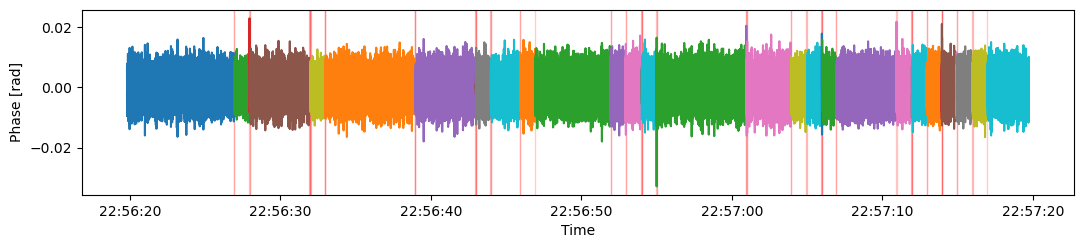

In [18]:
# plot filtered time series
cha = 14
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, filt_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    ax.plot(DASfuncs.sintela_to_datetime(t),d[:,cha]) # with datetime formatting
for gap in gap_list:
    # plt.axvspan(gap[0], gap[1], alpha=0.2, color='red')
    # the convertion to datatime takes long...
    ax.axvspan(DASfuncs.sintela_to_datetime(gap[0]), DASfuncs.sintela_to_datetime(gap[1]), alpha=0.2, color='red') # with datetime formatting
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

In [19]:
# fill filtered data into array
_, data_filt = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

Text(0.5, 0, 'Time [s]')

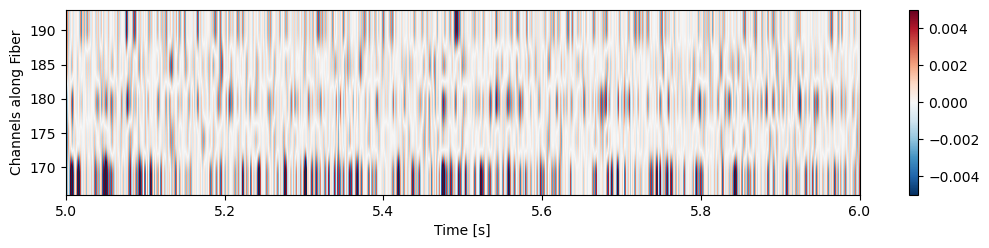

In [21]:
# plot filtered waterfall plot
fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
cha_start = 10
cha_end = 15
tstart = 5
tend = 6 # seconds
# left plot
im = ax.imshow(data_filt[int(attrs['PulseRate']*tstart):int(attrs['PulseRate']*tend),cha_start:cha_end].T, 
               aspect='auto',
             origin='lower',
             vmin=-0.005,#np.percentile(data[~np.isnan(data)],10),
             vmax=0.005,#np.percentile(data[~np.isnan(data)],90),
             extent=[tstart,tend, 
                  attrs['StartLocusIndex'],
                  attrs['StartLocusIndex']+data_rec.shape[1]],
             cmap='RdBu_r',
             # interpolation='none'
             )

cbar = plt.colorbar(im)
ax.set_ylabel('Channels along Fiber')
ax.set_xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

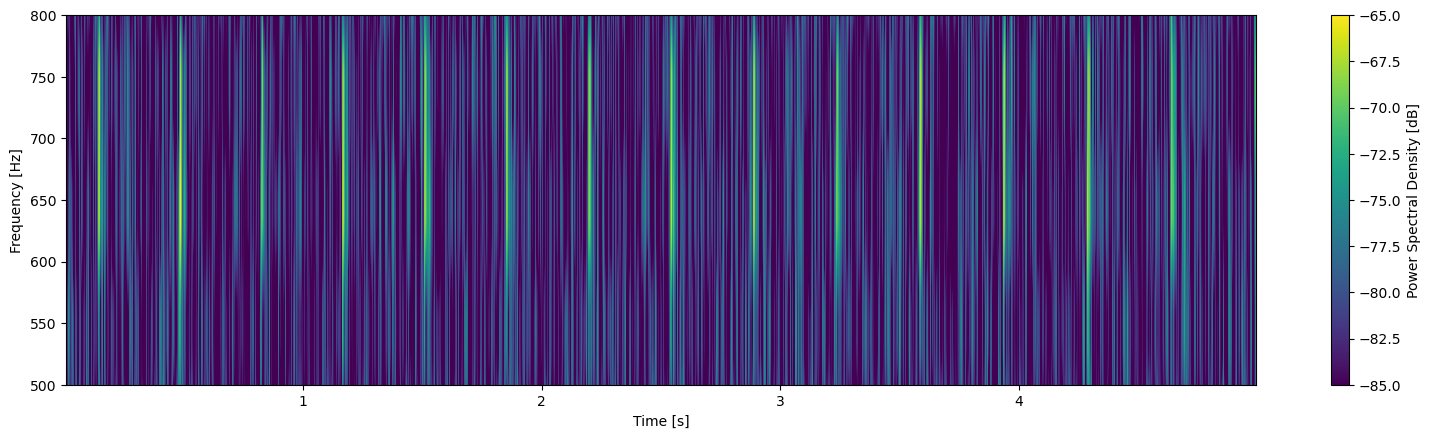

In [124]:
# plot a spectrogram of the median signal
fs = attrs['PulseRate']
spec_data = np.mean(data_filled[:int(fs*5),10:14], axis=1)

NFFT = fs*0.01
fig, ax = plt.subplots(figsize=(3*6.4,4.8))
Pxx, freqs, bins, im = ax.specgram(spec_data, 
                                    Fs=fs,
                                    NFFT=int(NFFT),
                                    noverlap=int(NFFT/1.1),
                                    detrend='linear',   # detrending before taking fourier transform
                                    mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True, # unit/Hz
                                    scale='dB',
                                    vmax=-65, vmin=-85#, cmap='jet'
                                   )

cbar = plt.colorbar(im)
cbar.set_label('Power Spectral Density [dB]') #colorbar label
ax.set_ylim(500,800)
# ax.set_yscale('log')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')

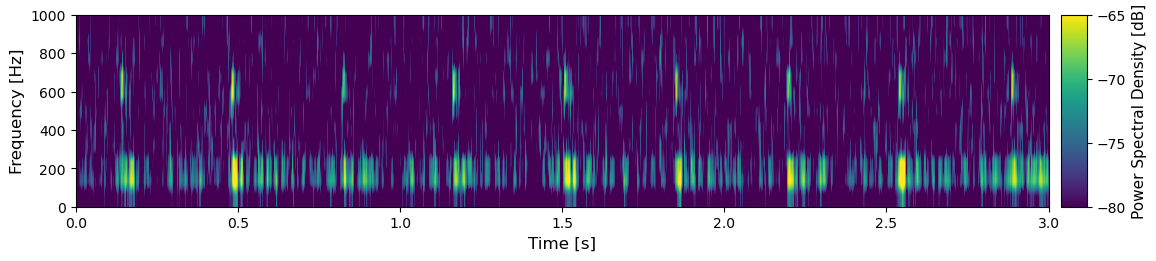

In [138]:
# plot the spectrogram
t_int=False,
cmap="viridis",
vmax=None
vmin=None # matplotlib color map
ylim=(0,1000)
yscale='log'

fig = plt.figure(figsize=(6.4*2,4.8/1.5))
ax = fig.add_axes([0.125, 0.125, 0.76, 0.6])      # main spectrogram
ax_cbar = fig.add_axes([0.895, 0.125, 0.02, 0.6]) # colorbar

# apply the ylim here - directly reduce the data
if ylim:
    idx_low = (np.abs(freqs - ylim[0])).argmin()
    idx_high = (np.abs(freqs - ylim[1])).argmin()+1
    Pxx_cut = Pxx[idx_low:idx_high,:]
    freqs_cut = freqs[idx_low:idx_high]
else:
    Pxx_cut = Pxx
    freqs_cut = freqs

im = ax.imshow(10*np.log10(Pxx_cut), 
               aspect='auto', 
               origin='lower', 
               # cmap=cmap,
               extent=[bins[0], bins[-1], freqs_cut[0], freqs_cut[-1]],
               vmax=-65, 
               vmin=-80
              )

cbar = plt.colorbar(im, cax=ax_cbar)
cbar.ax.locator_params(nbins=5)
cbar.set_label('Power Spectral Density [dB]', fontsize=11) #colorbar label

# set the x-ticks
# x_tickloc, x_ticks_str, x_label = nice_x_axis(stats, bins, t_int=t_int) # functions to plot nice x-axis
# ax.set_xticks(x_tickloc)
# ax.set_xticklabels(x_ticks_str)
# ax.set_xlabel(x_label, fontsize=12) 
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_ylabel('Frequency [Hz]', fontsize=12)
# ax.set_yscale('log')
ax.set_ylim(ylim)
ax.set_xlim([0,3])
fig.savefig('../../plots/NSF_proposal/bubbles.png', dpi=300, bbox_inches='tight')